#  <font color='#FFE15D'><b> Language Modeling</b></font>

# 🔴 **Import Libs**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torchtext
from torchtext import datasets

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

ModuleNotFoundError: No module named 'torchtext'

In [300]:
!python --version
print(torch.__version__)
print(torchtext.__version__)

96129.21s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Python 3.10.12
2.2.2+cu121
0.17.2+cpu


In [301]:
for lib in [np, torch, torchtext, tqdm]:
    print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
torch --> 2.2.2+cu121
torchtext --> 0.17.2+cpu
tqdm --> 4.66.2


# 🔴 **Utils**

In [302]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [303]:
def num_trainable_params(model):
    nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
    return nums

# 🔴 **Dataset**

## 🟠 **Load the Dataset**

🔰 In this session you should load WikiText2 dataset.

In [304]:
import os
from typing import Union, Tuple
from torchdata.datapipes.iter import FileOpener, IterableWrapper
from torchtext.data.datasets_utils import _wrap_split_argument, _create_dataset_directory

DATA_DIR = "data"

NUM_LINES = {
    "train": 36718,
    "valid": 3760,
    "test": 4358,
}

DATASET_NAME = "WikiText2"

_EXTRACTED_FILES = {
    "train": "wiki.train.tokens",
    "test": "wiki.test.tokens",
    "valid": "wiki.valid.tokens",
}


def _filepath_fn(root, split):
    return os.path.join(root, _EXTRACTED_FILES[split])


@_create_dataset_directory(dataset_name=DATASET_NAME)
@_wrap_split_argument(("train", "valid", "test"))

def WikiText2(root: str, split: Union[Tuple[str], str]):
    url_dp = IterableWrapper([_filepath_fn(DATA_DIR, split)])
    data_dp = FileOpener(url_dp, encoding="utf-8").readlines(strip_newline=False, return_path=False).shuffle().set_shuffle(False).sharding_filter()
    return data_dp

In [305]:
train_iter = WikiText2(root=DATA_DIR, split="train")
valid_iter = WikiText2(root=DATA_DIR, split="valid")
test_iter  = WikiText2(root=DATA_DIR, split="test")

In [306]:
train_iter_ = iter(train_iter)
train_iter_

<generator object ShardingFilterIterDataPipe.__iter__ at 0x79642cfa85f0>

In [307]:
next(train_iter_)

' \n'

## 🟠 **Build vocabulary and save it**

🔰 In this section we need to:

*   Define a tokenizer using `basic_english`
*   Tokenize the dataset and collect tokens
*   Build the vocabulary using `build_vocab_from_iterator`
*   Manually insert special tokens and set the default index


In [308]:
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

def build_and_save_vocabulary(train_iter, vocab_path='vocab.pt', min_freq=4):
    """
    Build a vocabulary from the training data iterator and save it to a file.
    
    Args:
        train_iter (iterator): An iterator over the training data.
        vocab_path (str, optional): The path to save the vocabulary file. Defaults to 'vocab.pt'.
        min_freq (int, optional): The minimum frequency of a word to be included in the vocabulary. Defaults to 4.
    
    Returns:
        torchtext.vocab.Vocab: The built vocabulary.
    """

    # Get the tokenizer
    tokenizer = get_tokenizer("basic_english")
    
    # Build the vocabulary
    vocab = build_vocab_from_iterator(map(tokenizer, train_iter), 
                                      specials=['<sos>', '<eos>', '<unk>'], 
                                      min_freq=min_freq)
    
    # Set the default index to the unknown token, and save vocab
    vocab.set_default_index(vocab['<unk>'])
    torch.save(vocab, vocab_path)
    
    return vocab

In [309]:
vocab = build_and_save_vocabulary(train_iter, vocab_path='my_vocab.pt')
len(vocab)

23654

In [311]:
dir(vocab.vocab)

['__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'append_token',
 'default_index_',
 'get_default_index',
 'get_itos',
 'get_stoi',
 'insert_token',
 'itos_',
 'lookup_indices',
 'lookup_token',
 'lookup_tokens',
 'set_default_index']

In [ ]:
from torchtext.vocab import build_vocab_from_iterator, GloVe

# Assuming `dataset` is your list of text samples
tokenizer = get_tokenizer("basic_english")

vocab = build_vocab_from_iterator(map(tokenizer, train_iter), 
                                  specials=['<sos>', '<eos>', '<unk>'], 
                                  min_freq=4)

# Step 2: Load the GloVe embeddings
glove_vectors = GloVe(name='6B', dim=100)

# Step 3: Create a new vocabulary with GloVe embeddings for tokens in the dataset
vocab_with_embeddings = {}
for idx, token in enumerate(vocab.vocab.itos_):
    if vocab.vocab.__contains__(token):
        vocab_with_embeddings[token] = glove_vectors[token]
        
# Example usage
print(vocab_with_embeddings.keys())

In [ ]:
vocab.vocab.itos_

In [63]:
# You can now use the vocabulary
print(len(vocab))
vocab(['ebi', 'AI'.lower(), 'qwerty', '<sos>', '<eos>', '<unk>'])

23654


[2, 1975, 2, 0, 1, 2]

## 🟠 EDA

### 🟡 Let's explore the WikiText2 dataset!

### 🟡 Calculate basic statistics such as the number of documents, total words, average document length, etc.

Mean sentence length in Wikitext-2:
Train: 21.69
Valid: 21.54
Test: 21.13


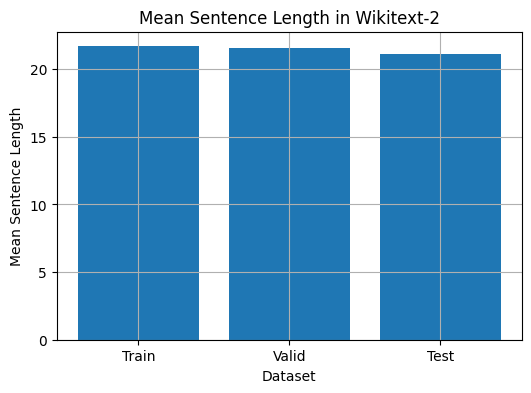

In [17]:
import matplotlib.pyplot as plt

def compute_mean_sentence_length(data_iter):
    """
    Computes the mean sentence length for the given data iterator.
    
    Args:
        data_iter (iterable): An iterable of text data, where each element is a string representing a line of text.
    
    Returns:
        float: The mean sentence length.
    """
    total_sentence_count = 0
    total_sentence_length = 0

    for line in data_iter:
        sentences = line.split('.')  # Split the line into individual sentences

        for sentence in sentences:
            tokens = sentence.strip().split()  # Tokenize the sentence
            sentence_length = len(tokens)

            if sentence_length > 0:
                total_sentence_count += 1
                total_sentence_length += sentence_length

    mean_sentence_length = total_sentence_length / total_sentence_count
    return mean_sentence_length

# Compute mean sentence length for each dataset
train_mean = compute_mean_sentence_length(train_iter)
valid_mean = compute_mean_sentence_length(valid_iter)
test_mean  = compute_mean_sentence_length(test_iter)

# Print the results
print(f'Mean sentence length in Wikitext-2:')
print(f'Train: {train_mean:.2f}')
print(f'Valid: {valid_mean:.2f}')
print(f'Test: {test_mean:.2f}')

# Plot the results
datasets = ['Train', 'Valid', 'Test']
means = [train_mean, valid_mean, test_mean]

plt.figure(figsize=(6, 4))
plt.bar(datasets, means)
plt.xlabel('Dataset')
plt.ylabel('Mean Sentence Length')
plt.title('Mean Sentence Length in Wikitext-2')
plt.grid(True)
plt.show()

### 🟡 Analyze the most common and least common words in the dataset.

In [16]:
from collections import Counter

# Compute word frequencies in the training dataset
freqs = Counter()
for tokens in map(tokenizer, train_iter):
    freqs.update(tokens)

# Find the 10 least common words
least_common_words = freqs.most_common()[:-11:-1]
print("Least Common Words:")
for word, count in least_common_words:
    print(f"{word}: {count}")

# Find the 10 most common words
most_common_words = freqs.most_common(10)
print("\nMost Common Words:")
for word, count in most_common_words:
    print(f"{word}: {count}")

Least Common Words:
gallinae: 3
intergrades: 3
northeasterly: 3
tuscola: 3
roundabouts: 3
zoromski: 3
forrester: 3
kreutzer: 3
prefaced: 3
philipp: 3

Most Common Words:
the: 130768
,: 102615
.: 83397
of: 57030
<unk>: 54625
and: 50735
in: 45015
to: 39521
a: 36523
=: 29570


### 🟡 Count the number of words that repeat 3 times, 4 times, and 5 times in the Wikitext-2 training dataset

In [18]:
from collections import Counter

# Compute word frequencies in the training dataset
freqs = Counter()
for tokens in map(tokenizer, train_iter):
    freqs.update(tokens)

# Count the number of words that repeat 3, 4, and 5 times
count_3 = count_4 = count_5 = 0
for word, freq in freqs.items():
    if freq == 3:
        count_3 += 1
    elif freq == 4:
        count_4 += 1
    elif freq == 5:
        count_5 += 1

print(f"Number of words that appear 3 times: {count_3}")
print(f"Number of words that appear 4 times: {count_4}")
print(f"Number of words that appear 5 times: {count_5}")

Number of words that appear 3 times: 5130
Number of words that appear 4 times: 3243
Number of words that appear 5 times: 2261


### 🟡  Word Length Distribution

- Compute the distribution of word lengths (i.e., the number of characters per word) in the dataset.
- This can reveal insights about the writing style or genre of the corpus.

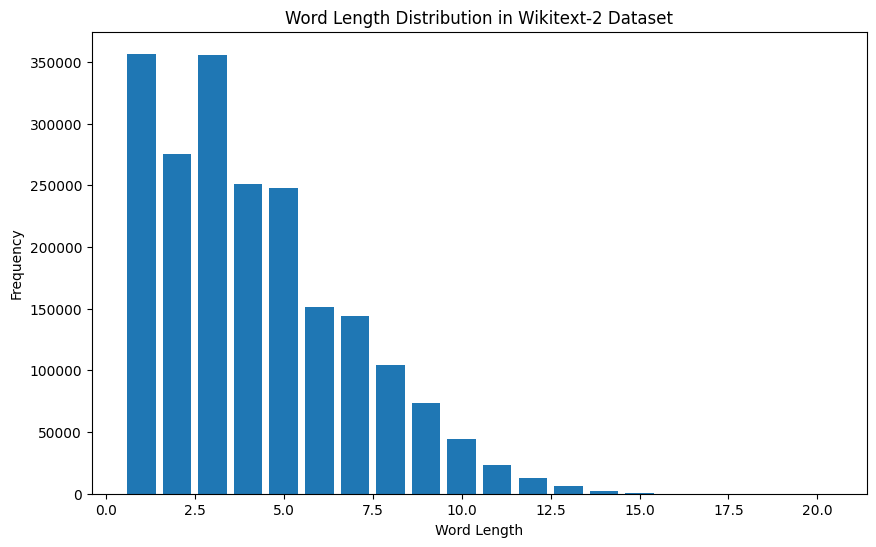

In [18]:
from collections import Counter
import matplotlib.pyplot as plt

# Compute the word lengths in the training dataset
word_lengths = []
for tokens in map(tokenizer, train_iter):
    word_lengths.extend(len(word) for word in tokens)

# Create a frequency distribution of word lengths
word_length_counts = Counter(word_lengths)

# Plot the word length distribution
plt.figure(figsize=(10, 6))
plt.bar(word_length_counts.keys(), word_length_counts.values())
plt.xlabel("Word Length")
plt.ylabel("Frequency")
plt.title("Word Length Distribution in Wikitext-2 Dataset")
plt.show()

### 🟡 Explore Part-of-Speech (POS) Tagging

- Perform part-of-speech tagging on the dataset to categorize words into grammatical classes (e.g., nouns, verbs, adjectives).
- Analyze the distribution of different POS tags and identify any interesting patterns or deviations from standard language models.

In [19]:
import spacy
import en_core_web_sm

nlp = spacy.load("en_core_web_sm")
nlp = en_core_web_sm.load()
doc = nlp("This is a sentence.")
print([(w.text, w.pos_) for w in doc])

[('This', 'PRON'), ('is', 'AUX'), ('a', 'DET'), ('sentence', 'NOUN'), ('.', 'PUNCT')]


In [ ]:
import spacy

# Load the English language model
nlp = spacy.load("en_core_web_sm")

# Perform POS tagging on the training dataset
pos_tags = []
for tokens in map(tokenizer, train_iter):
    doc = nlp(" ".join(tokens))
    pos_tags.extend([(token.text, token.pos_) for token in doc])

# Count the frequency of each POS tag
pos_tag_counts = Counter(tag for _, tag in pos_tags)

# Print the most common POS tags
print("Most Common Part-of-Speech Tags:")
for tag, count in pos_tag_counts.most_common(10):
    print(f"{tag}: {count}")

# Visualize the POS tag distribution
plt.figure(figsize=(12, 6))
plt.bar(pos_tag_counts.keys(), pos_tag_counts.values())
plt.xticks(rotation=90)
plt.xlabel("Part-of-Speech Tag")
plt.ylabel("Frequency")
plt.title("Part-of-Speech Tag Distribution in Wikitext-2 Dataset")
plt.show()

Here's a brief explanation of the most common POS tags in the provided output:

1. **NOUN**: Nouns are the most common part of speech, accounting for a significant portion of the text. Nouns represent people, places, things, or ideas.

2. **ADP**: Adpositions, such as prepositions and postpositions, are used to express relationships between words or phrases.

3. **PUNCT**: Punctuation marks, which are essential for separating and structuring sentences and text.

4. **VERB**: Verbs describe actions, states, or occurrences in the text.

5. **DET**: Determiners, such as articles (e.g., "the," "a," "an"), provide additional information about nouns.

6. **X**: This tag is often used for foreign words, abbreviations, or other language-specific tokens that don't fit into the standard POS categories.

7. **PROPN**: Proper nouns, which represent specific names of people, places, organizations, or other entities.

8. **ADJ**: Adjectives modify or describe nouns and pronouns.

9. **PRON**: Pronouns substitute for nouns, making the text more concise and less repetitive.

10. **NUM**: Numerals, which represent quantities, dates, or other numerical information.

This distribution of POS tags can provide insights into the linguistic characteristics of the text, such as the predominance of nouns, the prevalence of adpositions, or the usage of proper nouns, which can be helpful in tasks like text classification, information extraction, or stylometric analysis.

### 🟡 Investigate Named Entity Recognition:

- Apply named entity recognition (NER) to the dataset to identify and classify named entities (e.g., people, organizations, locations).
- Analyze the types and frequencies of named entities present in the corpus, which can provide insights into the content and focus of the Wikitext-2 dataset.

Most Common Named Entity Types:
DATE: 34280
CARDINAL: 28761
PERSON: 19093
GPE: 16455
NORP: 9392
ORDINAL: 8287
ORG: 8246
QUANTITY: 4115
LOC: 2015
MONEY: 1498


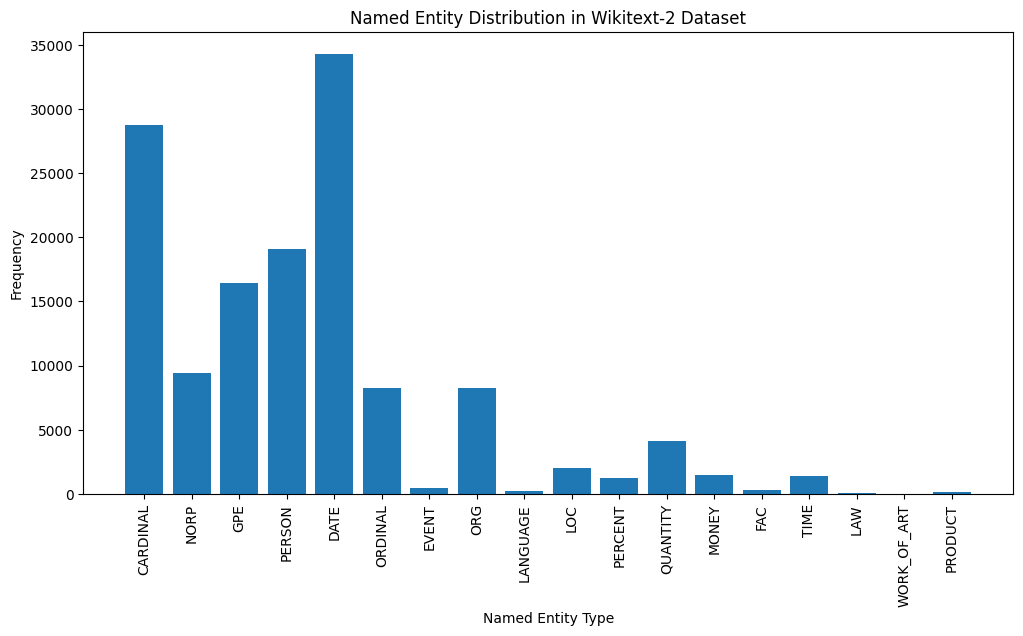

In [ ]:
import spacy
import matplotlib.pyplot as plt

# Load the English language model
nlp = spacy.load("en_core_web_sm")

# Perform NER on the training dataset
named_entities = []
for tokens in map(tokenizer, train_iter):
    doc = nlp(" ".join(tokens))
    named_entities.extend([(ent.text, ent.label_) for ent in doc.ents])

# Count the frequency of each named entity type
ner_counts = Counter(label for _, label in named_entities)

# Print the most common named entity types
print("Most Common Named Entity Types:")
for label, count in ner_counts.most_common(10):
    print(f"{label}: {count}")

# Visualize the named entity distribution
plt.figure(figsize=(12, 6))
plt.bar(ner_counts.keys(), ner_counts.values())
plt.xticks(rotation=90)
plt.xlabel("Named Entity Type")
plt.ylabel("Frequency")
plt.title("Named Entity Distribution in Wikitext-2 Dataset")
plt.show()

Here's a brief explanation of the most common named entity types in the output:

1. **DATE**: This entity type represents specific dates, time periods, or temporal expressions, such as "June 15, 2024" or "last year".

2. **CARDINAL**: This entity type includes numerical values, such as quantities, ages, or measurements.

3. **PERSON**: This entity type identifies the names of individual people.

4. **GPE** (Geopolitical Entity): This entity type represents named geographical locations, such as countries, cities, or states.

5. **NORP** (Nationalities, Religious, or Political Groups): This entity type includes named groups or affiliations based on nationality, religion, or political ideology.

6. **ORDINAL**: This entity type represents ordinal numbers, such as "first," "second," or "3rd".

7. **ORG** (Organization): This entity type identifies the names of companies, institutions, or other organized groups.

8. **QUANTITY**: This entity type includes non-numeric quantities, such as "a few" or "several".

9. **LOC** (Location): This entity type represents named geographical locations, such as continents, regions, or landforms.

10. **MONEY**: This entity type identifies monetary values, such as dollar amounts or currency names.

This distribution of named entity types can provide valuable insights into the content and focus of the text. For example, the prominence of DATE and CARDINAL entities may suggest a text that deals with numerical or temporal information, while the prevalence of PERSON, ORG, and GPE entities could indicate a text that discusses people, organizations, and geographical locations.

Understanding the named entity distribution can be useful in a variety of applications, such as information extraction, question answering, and text summarization, where identifying and categorizing key named entities is crucial for understanding the context and content of the text.

### 🟡 Perform Topic Modeling (To-do):

- Apply topic modeling techniques, such as Latent Dirichlet Allocation (LDA), to uncover the underlying thematic structure of the corpus.
- Analyze the identified topics and their distributions, which can reveal the main themes and subject areas covered in the Wikitext-2 dataset.

### 🟡 Generating a Word Cloud for the Wikitext-2 Training Dataset
This code generates a single word cloud visualization that highlights the most frequent words in the entire Wikitext-2 training dataset, providing a high-level overview of the prominent themes and topics present in the corpus.

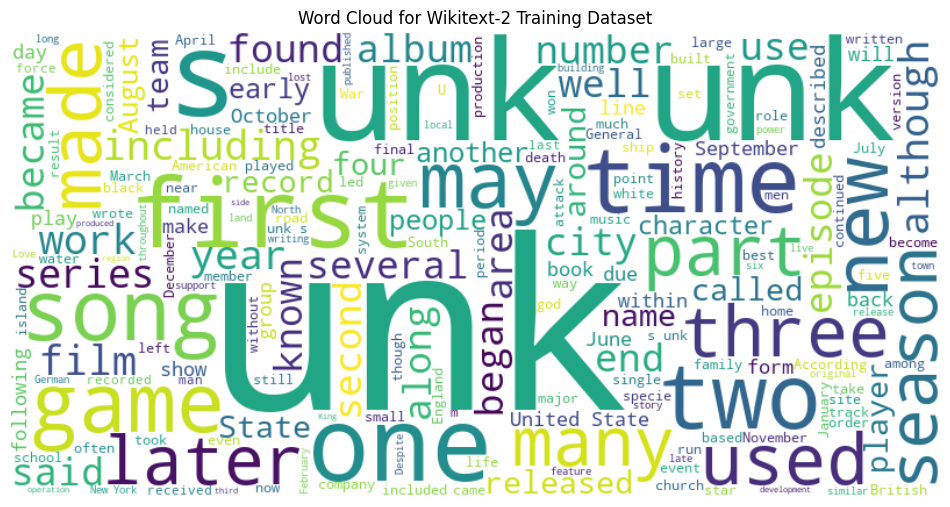

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the training dataset
with open("data/wiki.train.tokens", "r") as f:
    train_text = f.read().split()

# Create a string from the entire training dataset
text = " ".join(train_text)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Wikitext-2 Training Dataset')
plt.show()

### 🟡 Clustering Words by Semantic Similarity and Visualizing Word Clouds:

- This code clusters words from the Wikitext-2 dataset based on their semantic similarity using a BERT-based sentence transformer model, and then generates word clouds to visualize the most representative words in each semantic cluster.

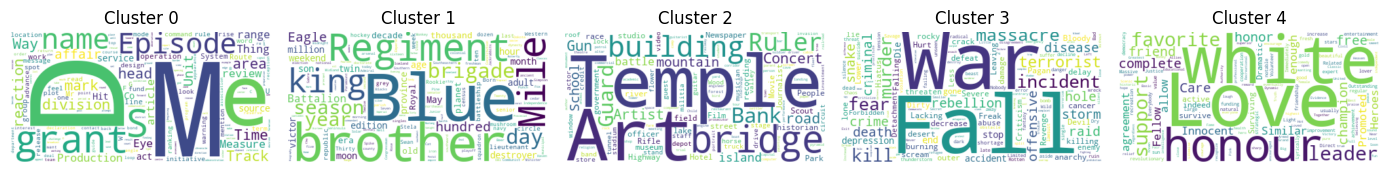

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the BERT-based sentence transformer model
model = SentenceTransformer('bert-base-nli-mean-tokens')

# Load the training dataset
with open("data/wiki.valid.tokens", "r") as f:
    train_text = f.read().split()

# Compute the BERT embeddings for each unique word in the dataset
unique_words = set(train_text)
word_embeddings = model.encode(list(unique_words))

# Cluster the words using K-Means
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(word_embeddings)

# Group the words by cluster
word_clusters = defaultdict(list)
for i, word in enumerate(unique_words):
    word_clusters[clusters[i]].append(word)

# Create a word cloud for each cluster
fig, axes = plt.subplots(1, 5, figsize=(14, 12))
axes = axes.flatten()

for cluster_id, cluster_words in word_clusters.items():
    word_cloud = WordCloud(width=400, height=200, background_color='white').generate(' '.join(cluster_words))
    axes[cluster_id].imshow(word_cloud, interpolation='bilinear')
    axes[cluster_id].set_title(f"Cluster {cluster_id}")
    axes[cluster_id].axis('off')

plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.tight_layout()
plt.show()

## 🟠 Transform the data

🛑 Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

The two data formats mentioned, `N x B x L` and `M x L`, are commonly used in language modeling tasks, particularly in the context of neural network-based models.

1. `N x B x L` format:
   - This format is often used when working with batched data for training neural network-based language models.
   - `N` represents the number of batches. In this case, the dataset is divided into `N` smaller batches, which is a common practice to improve the efficiency and stability of the training process.
   - `B` is the batch size, which represents the number of samples (e.g., sentences, paragraphs, or documents) within each batch.
   - `L` is the length of a sample within each batch, which typically corresponds to the number of tokens (words) in a sample.
   - This format allows the model to process multiple samples (batch) at once, which can significantly speed up the training process compared to processing one sample at a time.
   - The advantage of this format is that it enables efficient batch-based training, where the model can learn from multiple samples simultaneously, leveraging the computational power of modern hardware (e.g., GPUs) to accelerate the training process.

2. `M x L` format:
   - This format is simpler and more straightforward compared to the `N x B x L` format.
   - `M` is equal to `N x B`, which represents the total number of samples (e.g., sentences, paragraphs, or documents) in the dataset.
   - `L` is the length of each sample, which corresponds to the number of tokens (words) in the sample.
   - This format is less efficient for training neural network-based language models, as the samples are not organized into batches. However, it can be more suitable for certain tasks or when the dataset size is relatively small.
   - The advantage of this format is that it is easier to work with and can be more intuitive for certain data processing tasks, such as simple text analysis or feature extraction.

The choice between these two formats depends on the specific requirements of your language modeling task and the capabilities of the neural network architecture you're working with. If you're training a neural network-based language model, the `N x B x L` format is typically preferred, as it allows for efficient batch-based training and can lead to faster convergence and better performance. However, if your task doesn't involve neural networks or if the dataset is relatively small, the `M x L` format may be more suitable.

In [67]:
def prepare_language_model_data(raw_text_iterator, sequence_length):
    """
    Prepare PyTorch tensors for a language model.

    Args:
        raw_text_iterator (iterable): An iterator of raw text data.
        sequence_length (int): The length of the input and target sequences.

    Returns:
        tuple: A tuple containing two PyTorch tensors:
            - inputs (torch.Tensor): A tensor of input sequences.
            - targets (torch.Tensor): A tensor of target sequences.
    """
    # Convert the raw text iterator into a single PyTorch tensor
    data = torch.cat([torch.LongTensor([vocab['<sos>']] + vocab(tokenizer(line)) + [vocab['<eos>']]) for line in raw_text_iterator])
    data = torch.cat([torch.LongTensor(vocab(tokenizer(line)))+vocab['<eos>'] for line in raw_text_iterator])

    # Calculate the number of complete sequences that can be formed
    num_sequences = len(data) // sequence_length

    # Calculate the remainder of the data length divided by the sequence length
    remainder = len(data) % sequence_length

    # If the remainder is 0, add a single <unk> token to the end of the data tensor
    if remainder == 0:
        unk_tokens = torch.LongTensor([vocab['<unk>']])
        data = torch.cat([data, unk_tokens])

    # Extract the input and target sequences from the data tensor
    inputs  = data[:num_sequences*sequence_length].reshape(-1, sequence_length)
    targets = data[1:num_sequences*sequence_length+1].reshape(-1, sequence_length)

    return inputs, targets

In [68]:
inputs, targets = prepare_language_model_data(train_iter, 30)
inputs.shape, targets.shape

(torch.Size([68333, 30]), torch.Size([68333, 30]))

In [69]:
sequence_length = 30
X_train, y_train = prepare_language_model_data(train_iter, sequence_length)
X_valid, y_valid = prepare_language_model_data(valid_iter, sequence_length)
X_test, y_test   = prepare_language_model_data(test_iter, sequence_length)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

(torch.Size([68333, 30]),
 torch.Size([68333, 30]),
 torch.Size([7147, 30]),
 torch.Size([7147, 30]),
 torch.Size([8061, 30]),
 torch.Size([8061, 30]))

## 🟠 Custom dataset

🔰 Write a custom dataset class for LanguageModelDataset.

In [70]:
class LanguageModelDataset(Dataset):

  def __init__(self, inputs, targets):
    self.inputs = inputs
    self.targets = targets

  def __len__(self):
    return self.inputs.shape[0]

  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]

In [71]:
train_set = LanguageModelDataset(X_train, y_train)
valid_set = LanguageModelDataset(X_valid, y_valid)
test_set  = LanguageModelDataset(X_test, y_test)

In [72]:
train_set[0]
# len(train_set)

(tensor([   12,  3852,  3872,   884,    12, 20003,    86,  3852,    91,     3,
          3872,    24,   783,     3,     5,  6185,     6,  3852,     7,     4,
          5026,    91,    23,     5,  1840,  1021,    10,    17,  3852,  3872]),
 tensor([ 3852,  3872,   884,    12, 20003,    86,  3852,    91,     3,  3872,
            24,   783,     3,     5,  6185,     6,  3852,     7,     4,  5026,
            91,    23,     5,  1840,  1021,    10,    17,  3852,  3872,   884]))

## 🟠 Define a dataloader if needed

🔰 Write dataloaders for the training, validation, and test sets.

In [354]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

In [74]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([32, 30]), torch.Size([32, 30]))

In [355]:
x_batch, y_batch = next(iter(train_loader))
print(f"Input batch shape: {x_batch.shape}")
print(f"Target batch shape: {y_batch.shape}")

Input batch shape: torch.Size([32, 30])
Target batch shape: torch.Size([32, 30])


# 🔴 **Model**

🔰 Use the following template to create a custom model.

Your model should consist of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [76]:
class LanguageModel(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    pass
  
  def forward(self, src):
    pass

In [90]:
type(vocab)

torchtext.vocab.vocab.Vocab

In [356]:
import torch.nn as nn
from torchtext.vocab import GloVe, FastText


class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, 
                 hidden_dim, num_layers, dropout_embd=0.5, 
                 dropout_rnn=0.5, embedding_type='random'):
        
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.embedding_type = embedding_type

        if embedding_type == 'random':
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
            self.embedding.weight.data.uniform_(-0.1, 0.1)
 
        elif embedding_type == 'glove':
            self.glove = GloVe(name='6B', dim=embedding_dim)
    
            # Create an embedding matrix with the size of your vocabulary
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
    
            # Initialize the embedding weights with the GloVe vectors for the tokens in your vocabulary
            for i, token in enumerate(vocab.vocab.itos_):
                if token in self.glove.stoi:
                    self.embedding.weight.data[i] = self.glove.vectors[self.glove.stoi[token]]

            # Freeze the embedding weights to prevent them from being updated during training
            self.embedding.weight.requires_grad = False
        
        elif embedding_type == 'fasttext':
            self.fasttext = FastText(language="en")
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
            self.embedding.weight.data.copy_(self.fasttext.vectors)
            self.embedding.weight.requires_grad = False
        else:
            raise ValueError("Invalid embedding_type. Choose from 'random', 'glove', 'fasttext'.")

        self.dropout = nn.Dropout(p=dropout_embd)
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers=num_layers, 
                            dropout=dropout_rnn, 
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, src):
        embedding = self.dropout(self.embedding(src))
        output, hidden = self.lstm(embedding)
        prediction = self.fc(output)
        return prediction

In [357]:
model = LanguageModel(vocab_size=len(vocab),
                      embedding_dim=300,
                      hidden_dim=512,
                      num_layers=2,
                      dropout_embd=0.65,
                      dropout_rnn=0.5,
                      embedding_type='glove')
model

LanguageModel(
  (embedding): Embedding(23654, 300)
  (dropout): Dropout(p=0.65, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=512, out_features=23654, bias=True)
)

In [358]:
num_trainable_params(model.embedding), num_trainable_params(model.lstm), num_trainable_params(model.fc)

(0.0, 3.76832, 12.134502)

# 🔴 **Config**

In [359]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

🔰 Define the optimizer, loss function, metrics and other necessary parameters in this section, and ensure the model is sent to the appropriate device.

In [360]:
optimizer = optim.SGD(model.parameters(), lr=0.5, weight_decay=0, momentum=0.9, nesterov=True)
loss_fn   = nn.CrossEntropyLoss()
metric    = tm.text.Perplexity().to(device)

In [323]:
clip = 0.25

# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [361]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    if epoch:
        tepoch.set_description(f'Epoch {epoch}')

    for inputs, targets in tepoch:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

      loss.backward()

      nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [376]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss_eval.update(loss.item(), n=len(targets))

      metric.update(outputs, targets)

  return loss_eval.avg, metric.compute().item()

# 🔴 **Training Process**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [377]:
model = LanguageModel(vocab_size=len(vocab),
                      embedding_dim=300,
                      hidden_dim=512,
                      num_layers=2,
                      dropout_embd=0.65,
                      dropout_rnn=0.5,
                      embedding_type='glove')

inputs, targets = next(iter(train_set))
inputs, targets = inputs.to(device), targets.to(device)
 

with torch.no_grad():
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)

print(loss)

tensor(10.0660)


In [365]:
inputs.shape, targets.shape, outputs.shape

(torch.Size([30]), torch.Size([30]), torch.Size([30, 23654]))

In [366]:
len(vocab)

23654

### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [367]:
model = LanguageModel(vocab_size=len(vocab),
                      embedding_dim=300,
                      hidden_dim=512,
                      num_layers=2,
                      dropout_embd=0.65,
                      dropout_rnn=0.5,
                      embedding_type='glove').to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=2., momentum=0.9)

In [368]:
mini_train_size = 1000
_, mini_train_dataset = random_split(train_set, (len(train_set)-mini_train_size, mini_train_size))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, metric, epoch)

### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
num_epochs = 1

for lr in [2, 0.9, 0.5, 0.3, 0.09, 0.05]:
  print(f'LR={lr}')

  model = LanguageModel(len(vocab), 
                        embedding_dim=300,
                        hidden_dim=512, 
                        num_layers=2,
                        dropout_embd=0.5, 
                        dropout_rnn=0.2, 
                        embedding_type='glove').to(device)
  
#   model = torch.load('/content/model-ppl_147.pt')

  # optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0, momentum=0.9)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-6, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

  print()

### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [ ]:
num_epochs = 1

for lr in [3.]:
  for wd in [1e-6, 1e-4, 1e-5]:
    print(f'LR={lr}, WD={wd}')

    model = LanguageModel(len(vocab), 
                          embedding_dim=300,
                          hidden_dim=512, 
                          num_layers=2,
                          dropout_embd=0.5, 
                          dropout_rnn=0.2,
                          embedding_type='glove').to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

    for epoch in range(num_epochs):
      model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

    print()

### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [ ]:
model =

In [ ]:
lr =
wd =
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs =

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_set,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_set,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

## 🟠 Main Loop

🔰 Define model.

In [378]:
model = LanguageModel(vocab_size=len(vocab),
                      embedding_dim=300,
                      hidden_dim=512,
                      num_layers=2,
                      dropout_embd=0.65,
                      dropout_rnn=0.5,
                      embedding_type='glove').to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=2., momentum=0.9)

🔰 Define optimizer and Set learning rate and weight decay.

In [379]:
wd = 1e-4
lr = 2.
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

🔰 Write code to train the model for `num_epochs` epoches.

In [380]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [381]:
num_epochs = 30

for epoch in range(num_epochs):
  # Train
#   model, loss_train, metric_train = train_one_epoch(model,
#                                                  train_set,
#                                                  loss_fn,
#                                                  optimizer,
#                                                  metric,
#                                                  epoch)
  model, loss_train, metric_train = train_one_epoch(model, train_set, loss_fn, optimizer, metric, epoch)

  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_set,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

  0%|          | 0/68333 [00:00<?, ?batch/s]


ValueError: Input tensor `preds` is expected to have 3 dimensions, [batch_size, seq_len, vocab_size], but got 2.

## 🟠 Plot

🔰 Plot learning curves

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

🔰 Test your model using data from the test set

# 🔴 **Generate**

🔰 Your mission is to write a `generate` function and use a desired sentence to evaluate the model

In [ ]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

In [ ]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):
    pass